# Libraries

In [1]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from ipywidgets import widgets

from utilities.pathManager import fetchPaths
from utilities.utils import load_json, get_models

In [3]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [100]:
# DATASET = 'MNIST'
DATASET = 'FashionMNIST'
# DATASET = 'GTSRB'

In [101]:
paths = fetchPaths(base, DATASET, '', False)

path_bdd = paths['bdd'].parent
config = load_json(paths['configuration'])

flavors = config['configuration']['flavors']
batch_size = config['model_config']['batch_size']
lhl_neurons = config['configuration']['lhl_neurons']
optim = list(config['configuration']['optimizer'].keys())[0]

path_bdd

PosixPath('/home/ah19/runtime-monitoring/experiments/FashionMNIST/bdd')

# Import Data

In [102]:
# lhl_neurons = lhl_neurons[:-1]

In [103]:
model_names = []
for lhl, flavor in product(lhl_neurons, flavors):
    model_names.append(f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}')

In [104]:
model_names

['FashionMNIST_AdamW-64-5/raw',
 'FashionMNIST_AdamW-64-5/scaler_pca',
 'FashionMNIST_AdamW-64-30/raw',
 'FashionMNIST_AdamW-64-30/scaler_pca',
 'FashionMNIST_AdamW-64-60/raw',
 'FashionMNIST_AdamW-64-60/scaler_pca']

### Split all files

In [105]:
# for m in model_names:
    
#     m, f = m.split("/")
#     n = float(m.split("-")[-1])
    

#     all_file_name = {
#         'not_full': lambda x: path_bdd / m / f / f'all-thlds-{x}-3-{f}_{m}.csv',
#         'full': lambda x: path_bdd / m / f / f'all-thlds-full-{x}-3-{f}_{m}.csv'
#     }
    
#     for k in ['not_full', 'full']:
        
#         if not all_file_name[k]('info').is_file(): continue

#         info_ = pd.read_csv(all_file_name[k]('info'))
#         scores_ = pd.read_csv(all_file_name[k]('scores'))

#         for thld in info_['thld'].drop_duplicates():
#             for nn in info_['num_neurons'].drop_duplicates():

#                 subset = 'None'
#                 if f == 'raw':
#                     if n//3 == nn: subset = 'top_third'
#                     elif n != nn: subset = 'gte_mean'
#                 if f == 'scaler_pca':
#                     if n != nn: subset = 'components'


#                 single_file_name = {
#                     'not_full': lambda x: f'all-thlds-{x}-3-{subset}-{thld}-{f}_{m}.csv',
#                     'full': lambda x: f'all-thlds-full-{x}-3-{subset}-{thld}-{f}_{m}.csv'
#                 }
                

#                 if not (path_bdd / m / f / single_file_name[k]('info')).is_file():
                    
#                     print(all_file_name[k]('info').name)
                    
#                     info_.loc[(info_['num_neurons'] == nn) & (info_['thld'] == thld)].to_csv(
#                         path_bdd / m / f / single_file_name[k]('info'), index=False)

#                     scores_.loc[(scores_['num_neurons'] == nn) & (scores_['thld'] == thld)].to_csv(
#                         path_bdd / m / f / single_file_name[k]('scores'), index=False)

In [106]:
def read_df(path, f, lhl, bs):    
    d = pd.read_csv(path)
    d['flavor'] = f
    d['lhl'] = lhl
    d['batch_size'] = bs
    return d

def collect_dfs(path, key, f, lhl, bs, full):
    t = []
    
    if full: reg_name = f'all-thlds-full-{key}-3-{f}_*.csv'
    else: reg_name = f'all-thlds-{key}-3-{f}_*.csv'

    for p in path.glob(reg_name):
        t.append(read_df(p, f, lhl, bs))
    
    if t == []: return pd.DataFrame()
    return pd.concat(t)

In [107]:
full = 0

df_info = pd.concat(
    [collect_dfs(path_bdd / f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}', 'info', flavor, lhl, batch_size, full) \
    for lhl, flavor in product(lhl_neurons, flavors)])

df_score = pd.concat(
    [collect_dfs(path_bdd / f'{DATASET}_{optim}-{batch_size}-{lhl}/{flavor}', 'scores', flavor, lhl, batch_size, full ) \
    for lhl, flavor in product(lhl_neurons, flavors)])

In [108]:
df_info['num_neurons'] = df_info['num_neurons'].astype('int')
df_info['lhl'] = df_info['lhl'].astype('int')

for c in ['total_count', 'total_misclassified', 'unrecognized','unrecognized_and_misclassified', 'lhl', 'num_neurons']:
    df_score[c] = df_score[c].astype('int')

In [109]:
df_info['subset_name'] = np.where(
    # RAW
    df_info['flavor'] == 'raw',
    np.where(df_info['num_neurons'] == df_info['lhl'], 'raw',
    np.where(df_info['num_neurons'] == df_info['lhl']//3, 'top third', 'gte_mean')),
    # PCA
    np.where(df_info['num_neurons'] != df_info['lhl'], 'pca_components', 'scaler_pca')
)

df_info['build_time_hr'] = (df_info['build_time_min'] / 60).round(2)

# df_score['unrecognized_and_classified'] = \
#     (df_score['unrecognized'] - df_score['unrecognized_and_misclassified']) / \
#     (df_score['total_count'] - df_score['unrecognized'])

df_score['subset_name'] = np.where(df_score['subset_name'].isna(),
                                 df_score['flavor'],
                                 df_score['subset_name'])

# df_score.loc[df_score['stage'] == 'evaluation', 'unrecognized_%'] = 1 - df_score.loc[df_score['stage'] == 'evaluation', 'unrecognized_%']
df_score.loc[df_score['stage'] == 'evaluation', 'unrecognized_and_misclassified_%'] = 0

df_score.rename({'unrecognized_misclassified_%': 'unrecognized_and_misclassified_fit_%'}, axis=1, inplace=True)

df_score['unrecognized_and_misclassified_fit_%'] = \
    df_score['unrecognized_and_misclassified'] / df_score['total_misclassified']

In [110]:
# thld = 'qth_0.75'
# thld = 'qth_0.5'
# thld = 'qth_0.25'
# thld = 'mean'
thld = 'relu'

In [111]:
flavor = 'raw'
# flavor = 'scaler_pca'

In [112]:
# lhl = 5
lhl = 30
# lhl = 60
# lhl = 100
# lhl = 50
# lhl = 80
# lhl = 150

In [113]:
df_info.loc[
    (df_info['lhl'] == lhl) &\
    (df_info['flavor'] == flavor) &\
    (df_info['thld'] == thld),
    np.setdiff1d(df_info.columns, ['start_time', 'end_time'])
]

,batch_size,build_time_hr,build_time_min,eta,flavor,lhl,num_neurons,num_patterns,num_reorder,num_unique_patterns_%,reorder_time_min,size_mb,subset_name,thld
36,64,0.01,0.667,0.0,raw,30,30,57501.0,0.0,29.1,0.0,4308.1,raw,relu
37,64,0.23,13.633,1.0,raw,30,30,502320.0,0.0,88.2,0.0,4313.0,raw,relu
38,64,0.07,4.333,2.0,raw,30,30,242056.0,0.0,96.1,0.0,4313.8,raw,relu
39,64,0.03,1.967,3.0,raw,30,30,121868.0,0.0,98.5,0.0,4314.0,raw,relu
40,64,0.00,0.033,0.0,raw,30,16,57501.0,0.0,5.8,0.0,4304.0,gte_mean,relu
41,64,0.02,0.900,1.0,raw,30,16,53360.0,0.0,64.5,0.0,4304.5,gte_mean,relu
42,64,0.01,0.317,2.0,raw,30,16,24343.0,0.0,80.4,0.0,4304.6,gte_mean,relu
43,64,0.00,0.117,3.0,raw,30,16,10661.0,0.0,88.5,0.0,4304.6,gte_mean,relu
44,64,0.00,0.000,0.0,raw,30,10,57501.0,0.0,1.0,0.0,4303.6,top third,relu
45,64,0.00,0.067,1.0,raw,30,10,5590.0,0.0,29.9,0.0,4303.6,top third,relu


In [114]:
# fltr = (df_score['num_neurons'] == lhl) & \
# (df_score['subset_name']==flavor) & \
# (df_score['y']=='all') & \
# (df_score['eta']==0)

fltr = (df_score['subset_name']==flavor) & \
(df_score['y']=='all') & \
(df_score['eta']==0)

In [115]:
df_score.loc[fltr & (df_score['stage']=='test')]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_%,unrecognized_and_misclassified_%,unrecognized_and_misclassified_fit_%,eta,subset_name,num_neurons,stage,thld,flavor,lhl,batch_size
54,all,9984,828,0,0,0.000000,0.000000,0.000000,0,raw,5,test,qth_0.75,raw,5,64
342,all,9984,828,0,0,0.000000,0.000000,0.000000,0,raw,5,test,qth_0.5,raw,5,64
630,all,9984,828,0,0,0.000000,0.000000,0.000000,0,raw,5,test,qth_0.25,raw,5,64
918,all,9984,828,0,0,0.000000,0.000000,0.000000,0,raw,5,test,relu,raw,5,64
1206,all,9984,828,0,0,0.000000,0.000000,0.000000,0,raw,5,test,mean,raw,5,64
54,all,9984,752,996,196,0.099760,0.196787,0.260638,0,raw,30,test,qth_0.75,raw,30,64
342,all,9984,752,2972,499,0.297676,0.167900,0.663564,0,raw,30,test,qth_0.5,raw,30,64
630,all,9984,752,3442,295,0.344752,0.085706,0.392287,0,raw,30,test,qth_0.25,raw,30,64
918,all,9984,752,2296,451,0.229968,0.196429,0.599734,0,raw,30,test,relu,raw,30,64
1206,all,9984,752,2009,405,0.201222,0.201593,0.538564,0,raw,30,test,mean,raw,30,64


In [116]:
df_score.loc[fltr & (df_score['stage']=='evaluation')]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_%,unrecognized_and_misclassified_%,unrecognized_and_misclassified_fit_%,eta,subset_name,num_neurons,stage,thld,flavor,lhl,batch_size
89,all,1000,0,0,0,0.000,0.0,NaN,0,raw,5,evaluation,qth_0.75,raw,5,64
377,all,1000,0,1,0,0.001,0.0,NaN,0,raw,5,evaluation,qth_0.5,raw,5,64
665,all,1000,0,0,0,0.000,0.0,NaN,0,raw,5,evaluation,qth_0.25,raw,5,64
953,all,1000,0,1,0,0.001,0.0,NaN,0,raw,5,evaluation,relu,raw,5,64
1241,all,1000,0,26,0,0.026,0.0,NaN,0,raw,5,evaluation,mean,raw,5,64
89,all,1000,0,699,0,0.699,0.0,NaN,0,raw,30,evaluation,qth_0.75,raw,30,64
377,all,1000,0,946,0,0.946,0.0,NaN,0,raw,30,evaluation,qth_0.5,raw,30,64
665,all,1000,0,559,0,0.559,0.0,NaN,0,raw,30,evaluation,qth_0.25,raw,30,64
953,all,1000,0,906,0,0.906,0.0,NaN,0,raw,30,evaluation,relu,raw,30,64
1241,all,1000,0,935,0,0.935,0.0,NaN,0,raw,30,evaluation,mean,raw,30,64


## Visualization

In [117]:
def add_bar_labels(sea, label_type=1):
    for k, ax in sea.axes_dict.items():
        # start y from 0
        ax.set_ylim(0, 1)
        # add data labels
        for container in ax.containers:
            ax.bar_label(container, fmt=lambda x: f'{x*100:.0f}%' if x > 0.05 else '',
                         label_type='center' if label_type else 'edge', c='white', fontsize=8)
        # rotate x axis
        for item in ax.get_xticklabels():
            item.set_rotation(90)
            
    sea.set_titles(row_template='{row_name}', col_template='{col_name}')
    try:sea.tight_layout()
    except: ...

In [118]:
flavor_order=['top_third', 'gte_mean', 'raw', 'scaler_pca', 'components']
thld_order=['mean', 'relu', 'qth_0.75', 'qth_0.5', 'qth_0.25']
metric_order = ['unrecognized_%','unrecognized_and_misclassified_%','unrecognized_and_misclassified_fit_%']

In [119]:
num_neurons = 30

## Showing Raw Metrics - ReLU

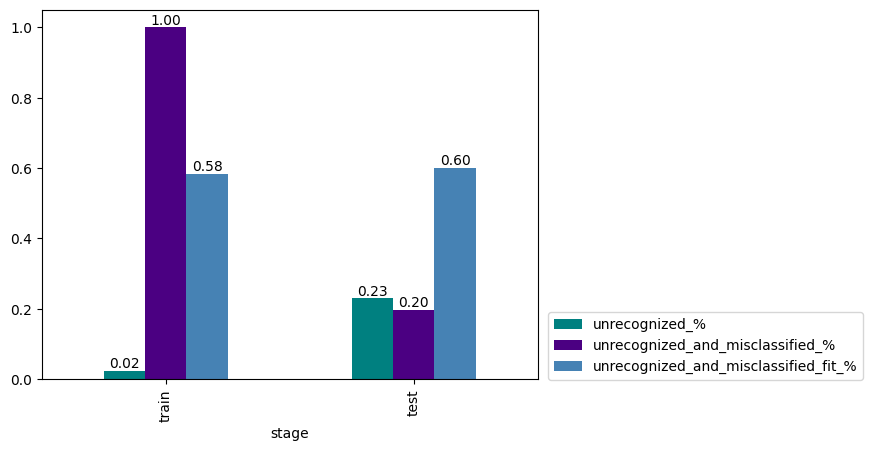

In [120]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] != 'evaluation') & \
    (df_score['flavor'] == 'raw') & \
    (df_score['subset_name'] == 'raw') & \
    (df_score['thld'] == 'relu') & \
    (df_score['num_neurons'] == num_neurons)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['stage', 'flavor']]
palette=['teal', 'indigo', 'steelblue']


ax = scores_best_thld_df.plot.bar(x='stage', color=palette)
ax.legend(loc='best', bbox_to_anchor=(1.17, -0.3, 0.5, 0.5))
for c in ax.containers: ax.bar_label(c, fmt=lambda x: f'{x:.2f}')
# ax.set_title(f'{DATASET} - {num_neurons} - ReLU')

plt.show()

# Raw vs PCA Metrics - ReLU

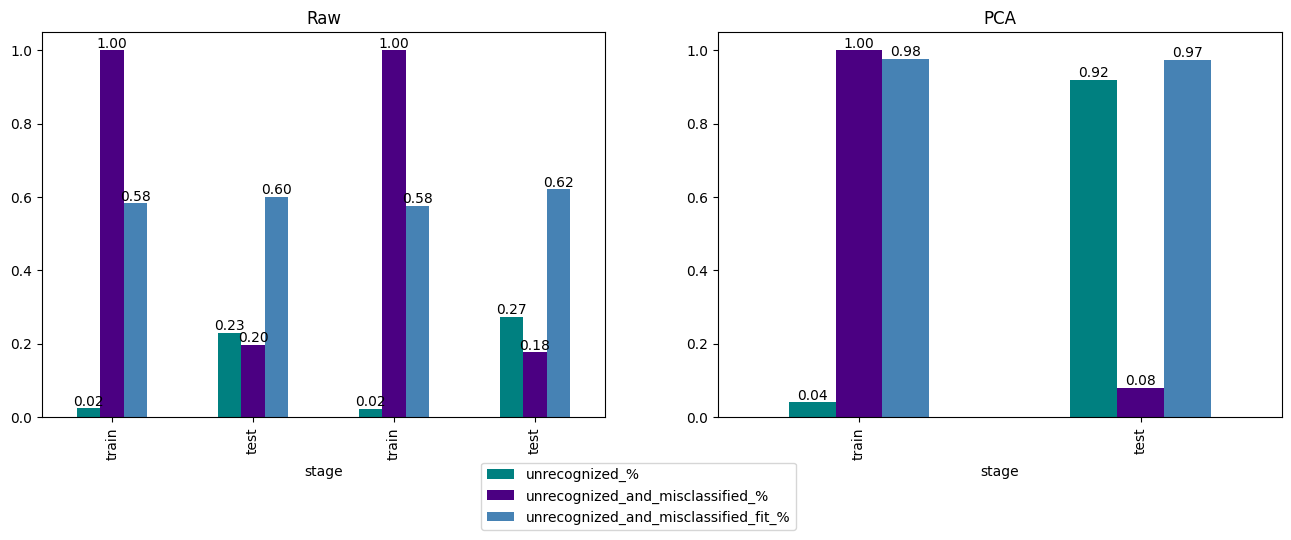

In [121]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] != 'evaluation') & \
    (df_score['thld'] == 'relu') & \
    (df_score['num_neurons'] == num_neurons)

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['stage', 'flavor']]
palette=['teal', 'indigo', 'steelblue']

fig, ax = plt.subplots(1, 2, figsize=(16,5))

scores_best_thld_df.loc[scores_best_thld_df['flavor']=='raw'].plot.bar(x='stage', color=palette, ax=ax[0])
ax[0].get_legend().remove()
for c in ax[0].containers: ax[0].bar_label(c, fmt=lambda x: f'{x:.2f}')
ax[0].set_title('Raw')

scores_best_thld_df.loc[scores_best_thld_df['flavor']=='scaler_pca'].plot.bar(x='stage', color=palette, ax=ax[1])
ax[1].legend(loc='best', bbox_to_anchor=(-0.35, -0.6, 0.5, 0.5))
for c in ax[1].containers: ax[1].bar_label(c, fmt=lambda x: f'{x:.2f}')
ax[1].set_title('PCA')

# fig.suptitle(f'{DATASET} - {num_neurons} - ReLU')

plt.show()

# Raw vs PCA Metrics - ReLU - All Models

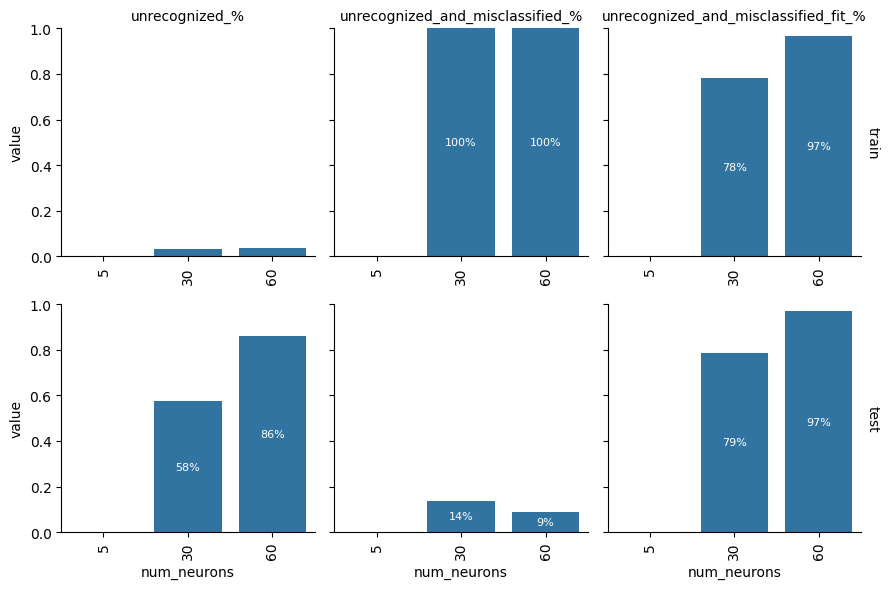

In [122]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] != 'evaluation') & \
    (df_score['thld'] == 'relu') & \
    (df_score['flavor'].isin(['raw', 'scaler_pca'])) & \
    (df_score['subset_name'].isin(['raw', 'scaler_pca']))

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['stage', 'flavor', 'num_neurons']]
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['stage', 'flavor', 'num_neurons']
)

palette = sns.color_palette('Greens_d', 3)

sea = sns.FacetGrid(scores_best_thld_df, col="metric", row="stage", margin_titles=True, sharex=False, palette=palette)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', errorbar=None)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

# Raw Metrics - All THLDS - All Models

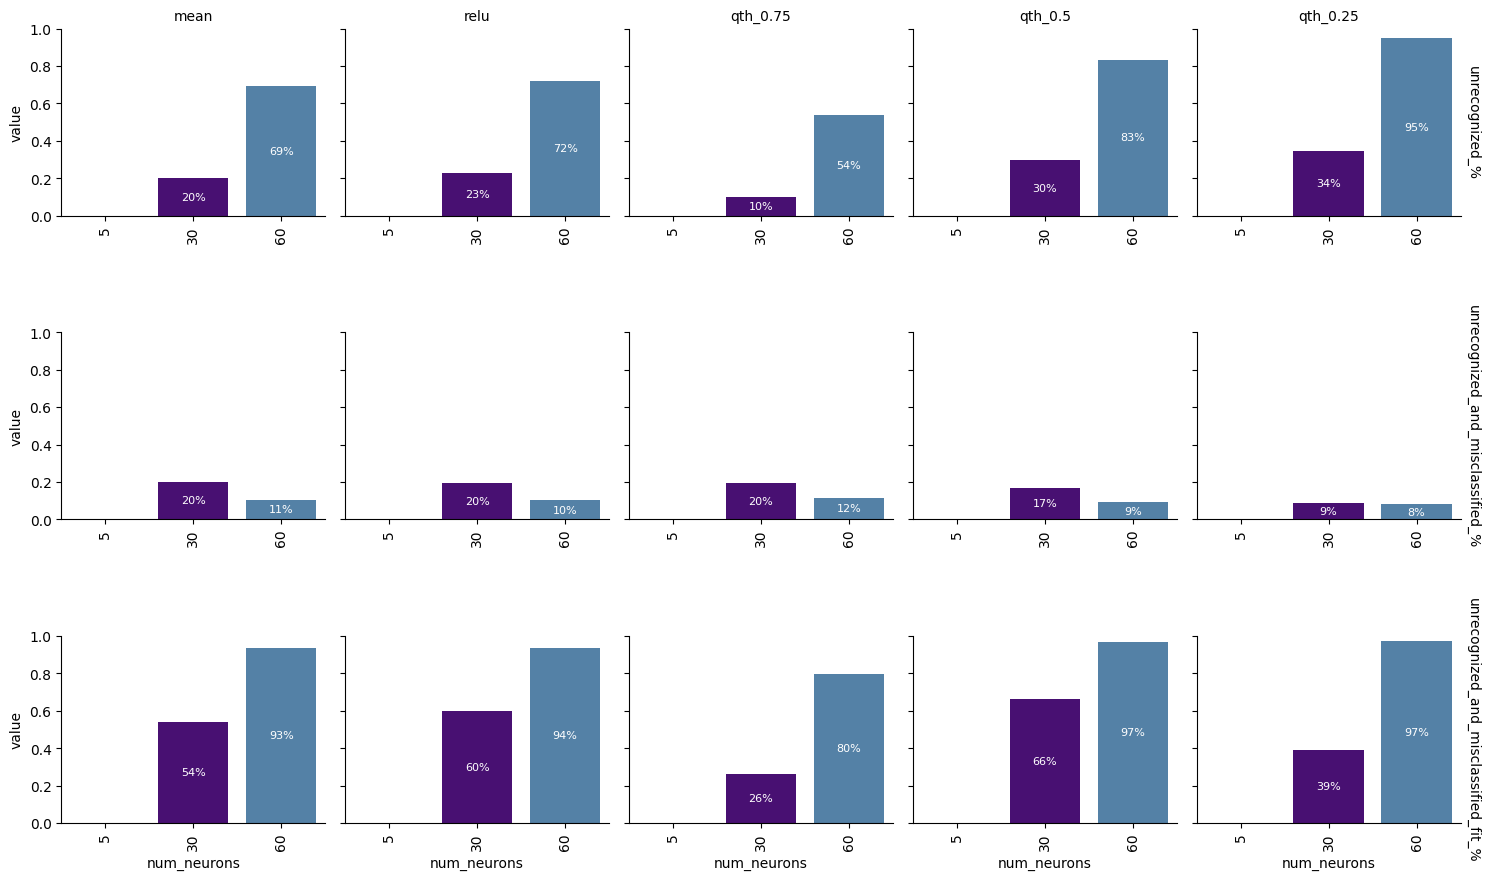

In [123]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] == 'test') & \
    (df_score['flavor'] == 'raw') & \
    (df_score['subset_name'] == 'raw')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons']]
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="metric", margin_titles=True, sharex=False,
                   col_order=thld_order)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

# PCA Metrics - All THLDS - All Models

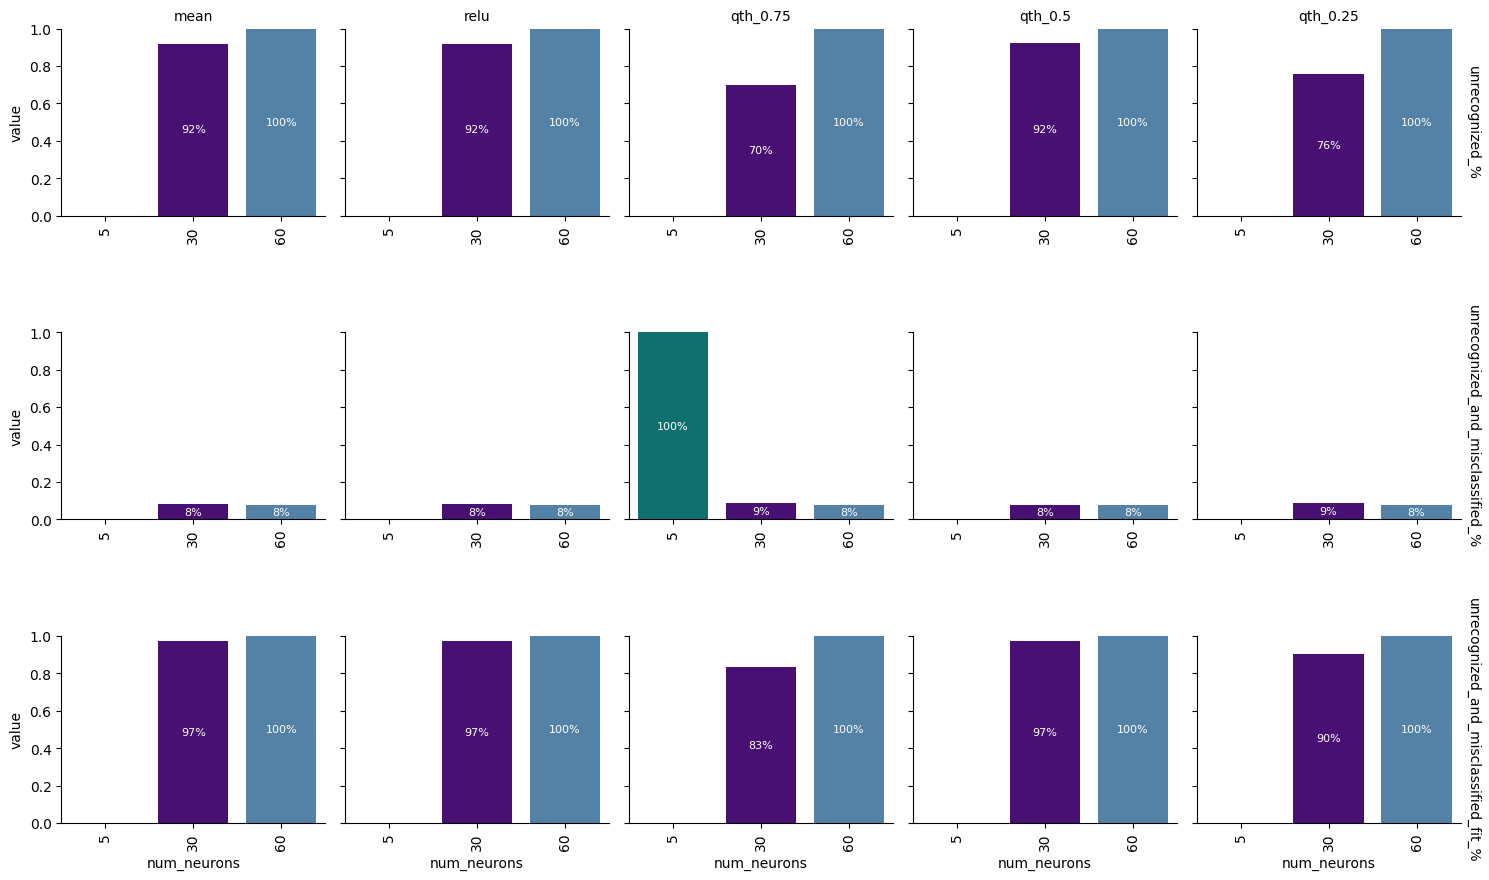

In [124]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] == 'test') & \
    (df_score['flavor'] == 'scaler_pca') & \
    (df_score['subset_name'] == 'scaler_pca')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons']]
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="metric", margin_titles=True, sharex=False,
                   col_order=thld_order)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

# RAW Metrics - All THLDS - All Models & NS

In [125]:
df_score['num_neurons'] = df_score.apply(lambda x: f"{x['lhl']} ({x['num_neurons']})", axis=1)

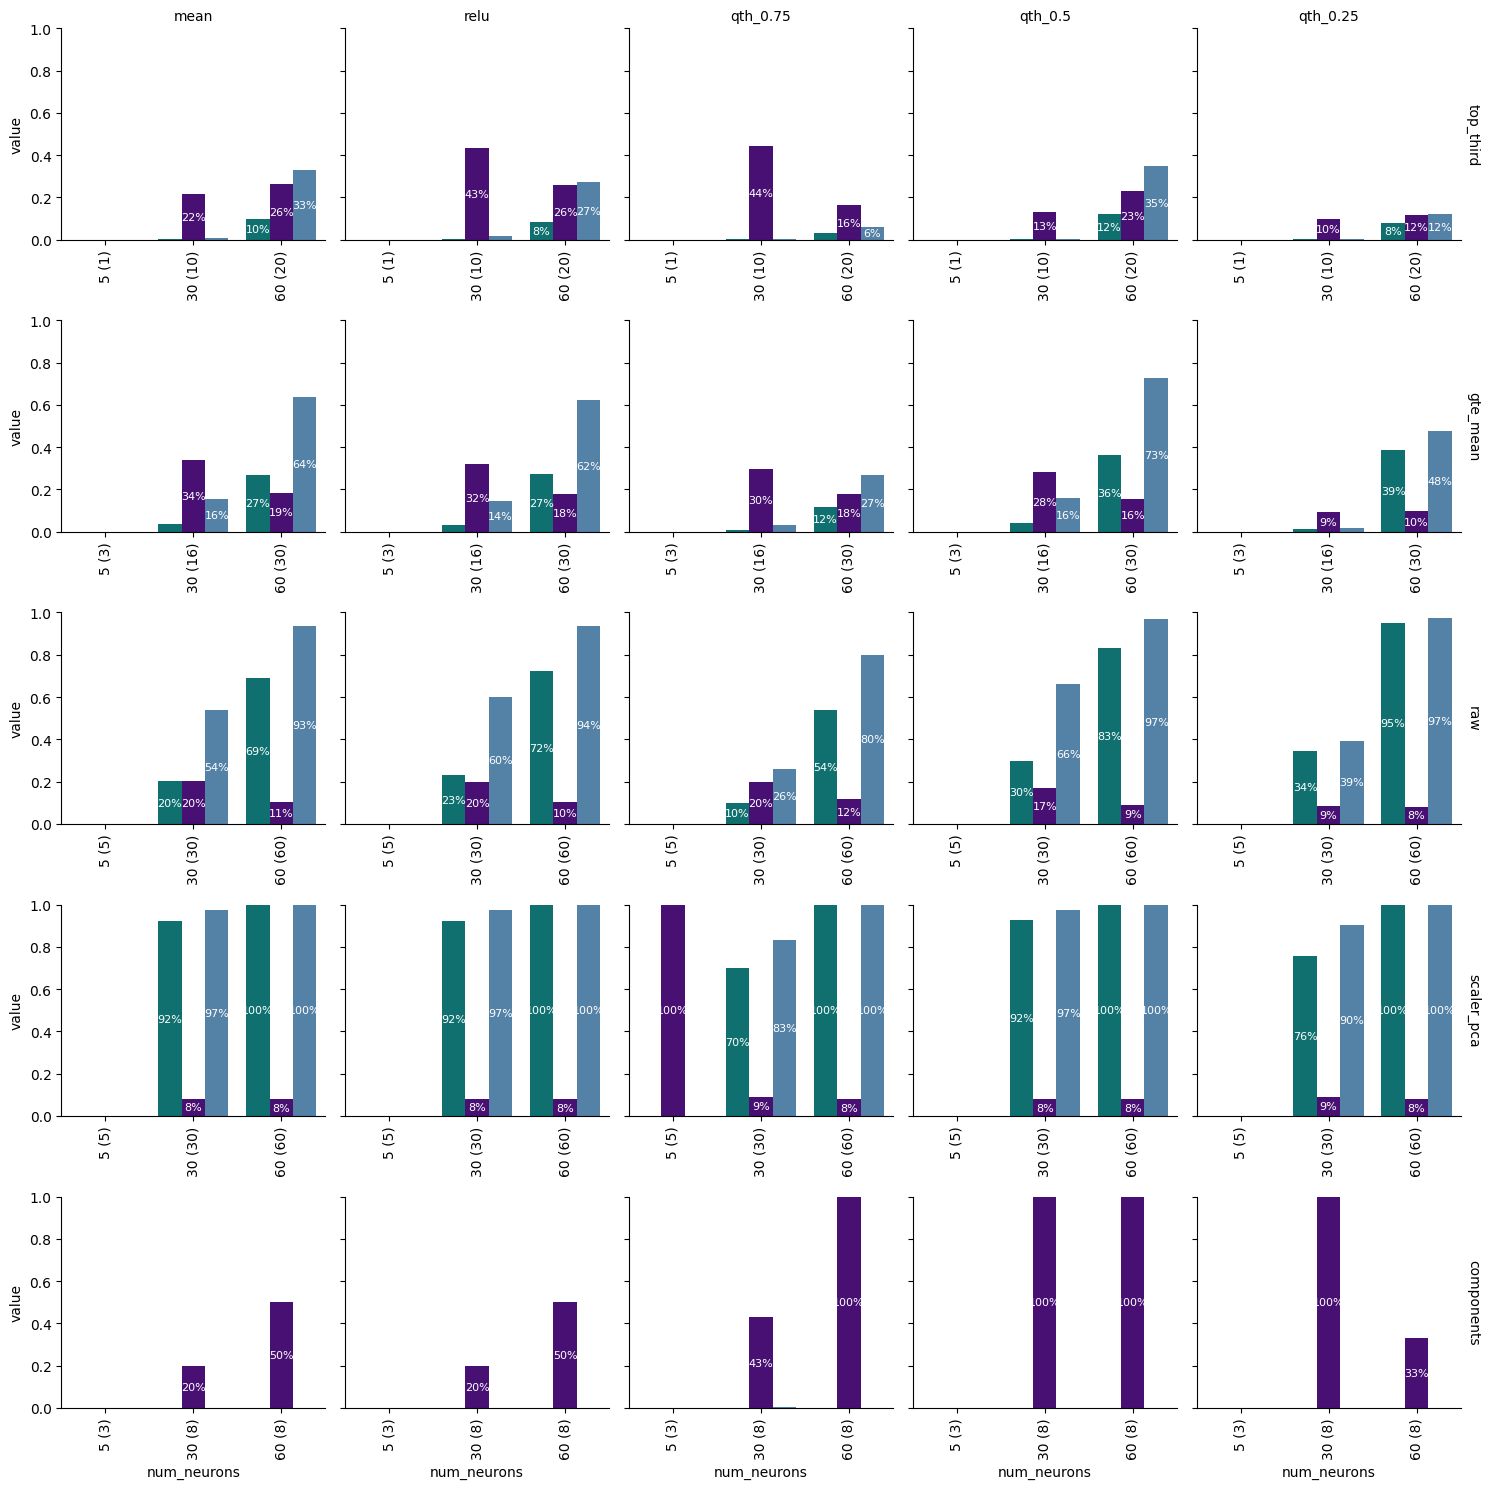

In [126]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] == 'test')

# scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['flavor', 'thld', 'num_neurons', 'subset_name']]

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons', 'subset_name']]

palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons', 'subset_name']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="subset_name", margin_titles=True, sharex=False,
                   row_order=flavor_order, col_order=thld_order)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', hue="metric", errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

# RAW Metrics - All THLDS - _ONE Model_ & NS

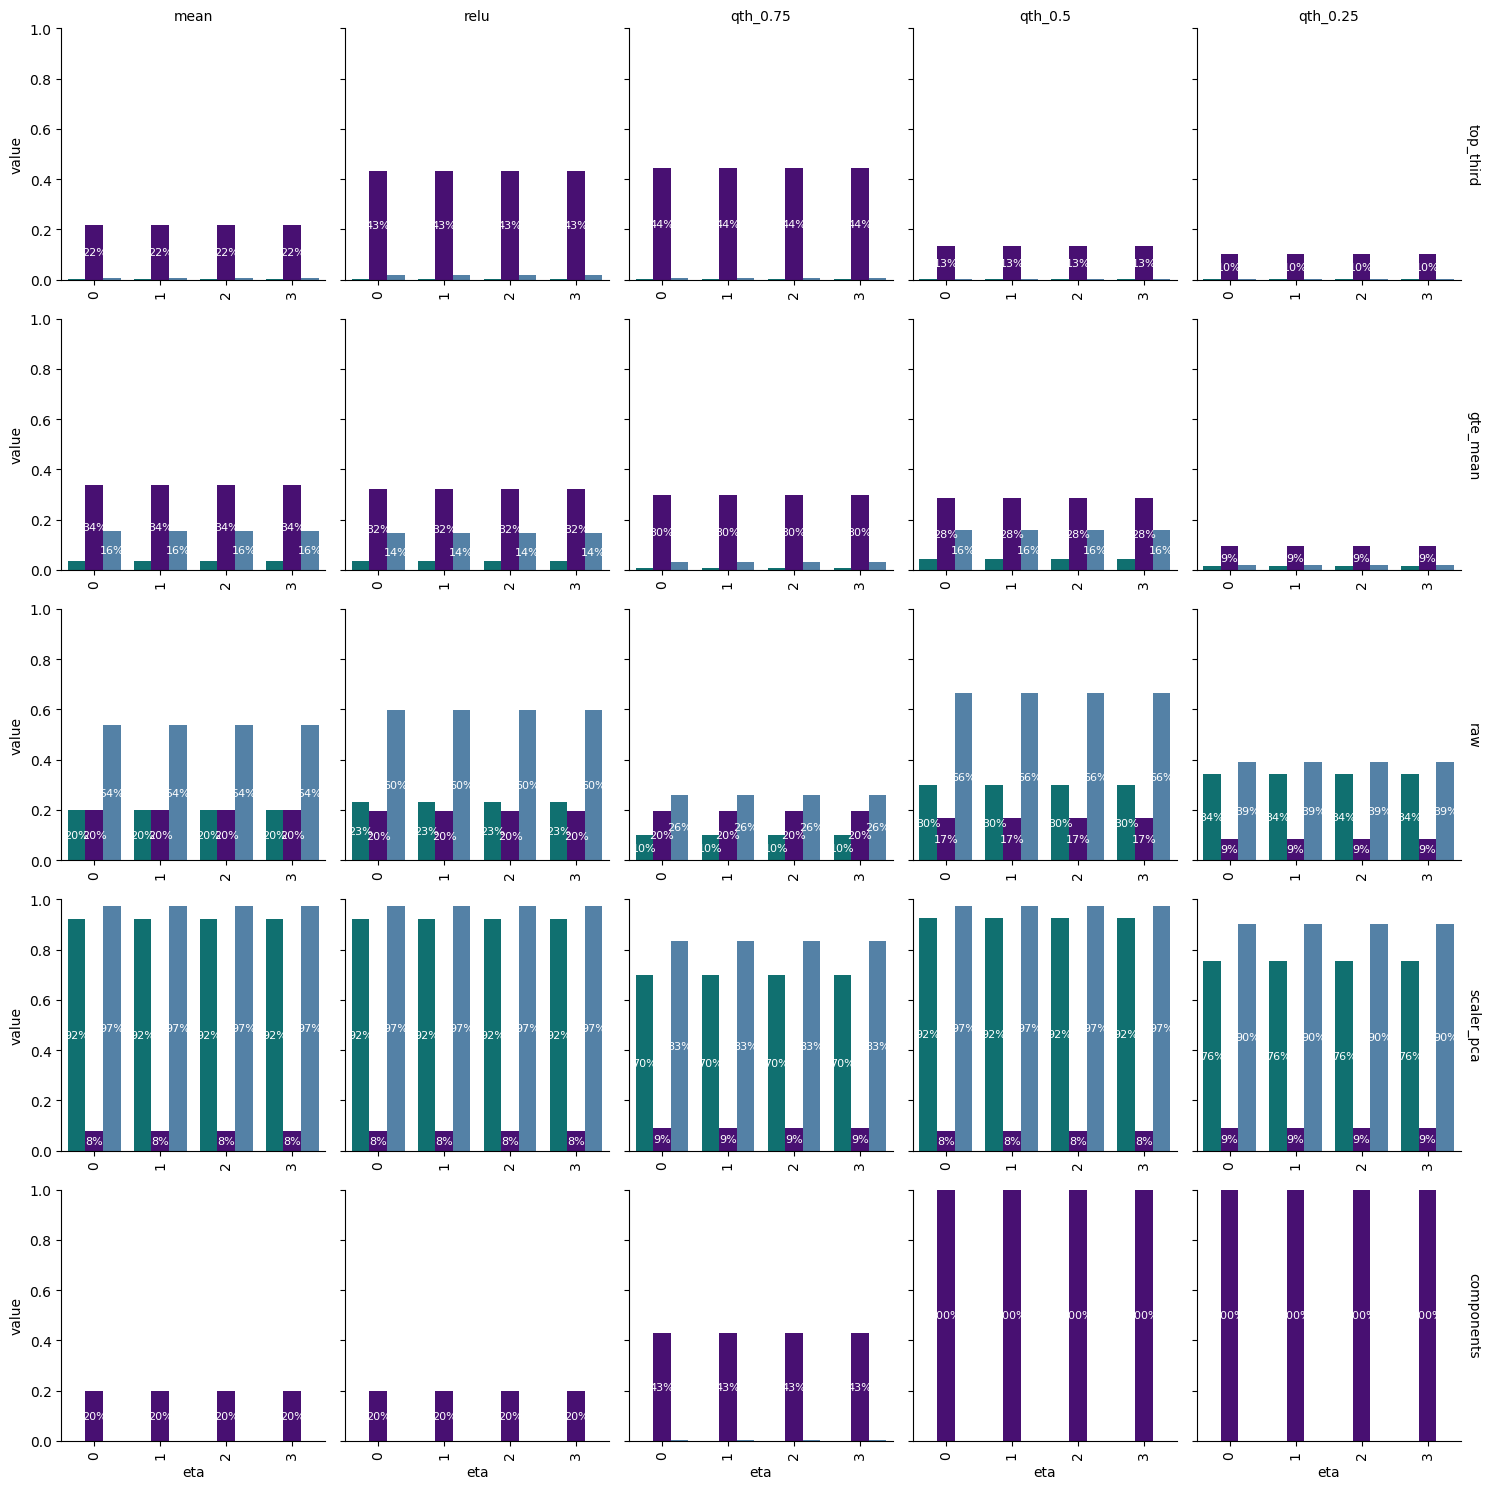

In [127]:
lhl = 30

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['stage'] == 'test')

# scores_best_thld_df = df_score.loc[scores_best_thld, metric_order[:-1] + ['flavor', 'thld', 'num_neurons', 'subset_name', 'eta']]
scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons', 'subset_name', 'eta']]

palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons', 'subset_name', 'eta']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="subset_name", margin_titles=True, sharex=False,
                   row_order=flavor_order, col_order=thld_order)

sea.map_dataframe(sns.barplot, "eta", 'value', hue="metric", errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [128]:
scores_best_thld_df.loc[scores_best_thld_df['subset_name'] == 'components']

,thld,flavor,num_neurons,subset_name,eta,metric,value
64,qth_0.75,scaler_pca,30 (8),components,0,unrecognized_%,0.000701
65,qth_0.75,scaler_pca,30 (8),components,1,unrecognized_%,0.000701
66,qth_0.75,scaler_pca,30 (8),components,2,unrecognized_%,0.000701
67,qth_0.75,scaler_pca,30 (8),components,3,unrecognized_%,0.000701
72,qth_0.5,scaler_pca,30 (8),components,0,unrecognized_%,0.000100
73,qth_0.5,scaler_pca,30 (8),components,1,unrecognized_%,0.000100
74,qth_0.5,scaler_pca,30 (8),components,2,unrecognized_%,0.000100
75,qth_0.5,scaler_pca,30 (8),components,3,unrecognized_%,0.000100
80,qth_0.25,scaler_pca,30 (8),components,0,unrecognized_%,0.000300
81,qth_0.25,scaler_pca,30 (8),components,1,unrecognized_%,0.000300


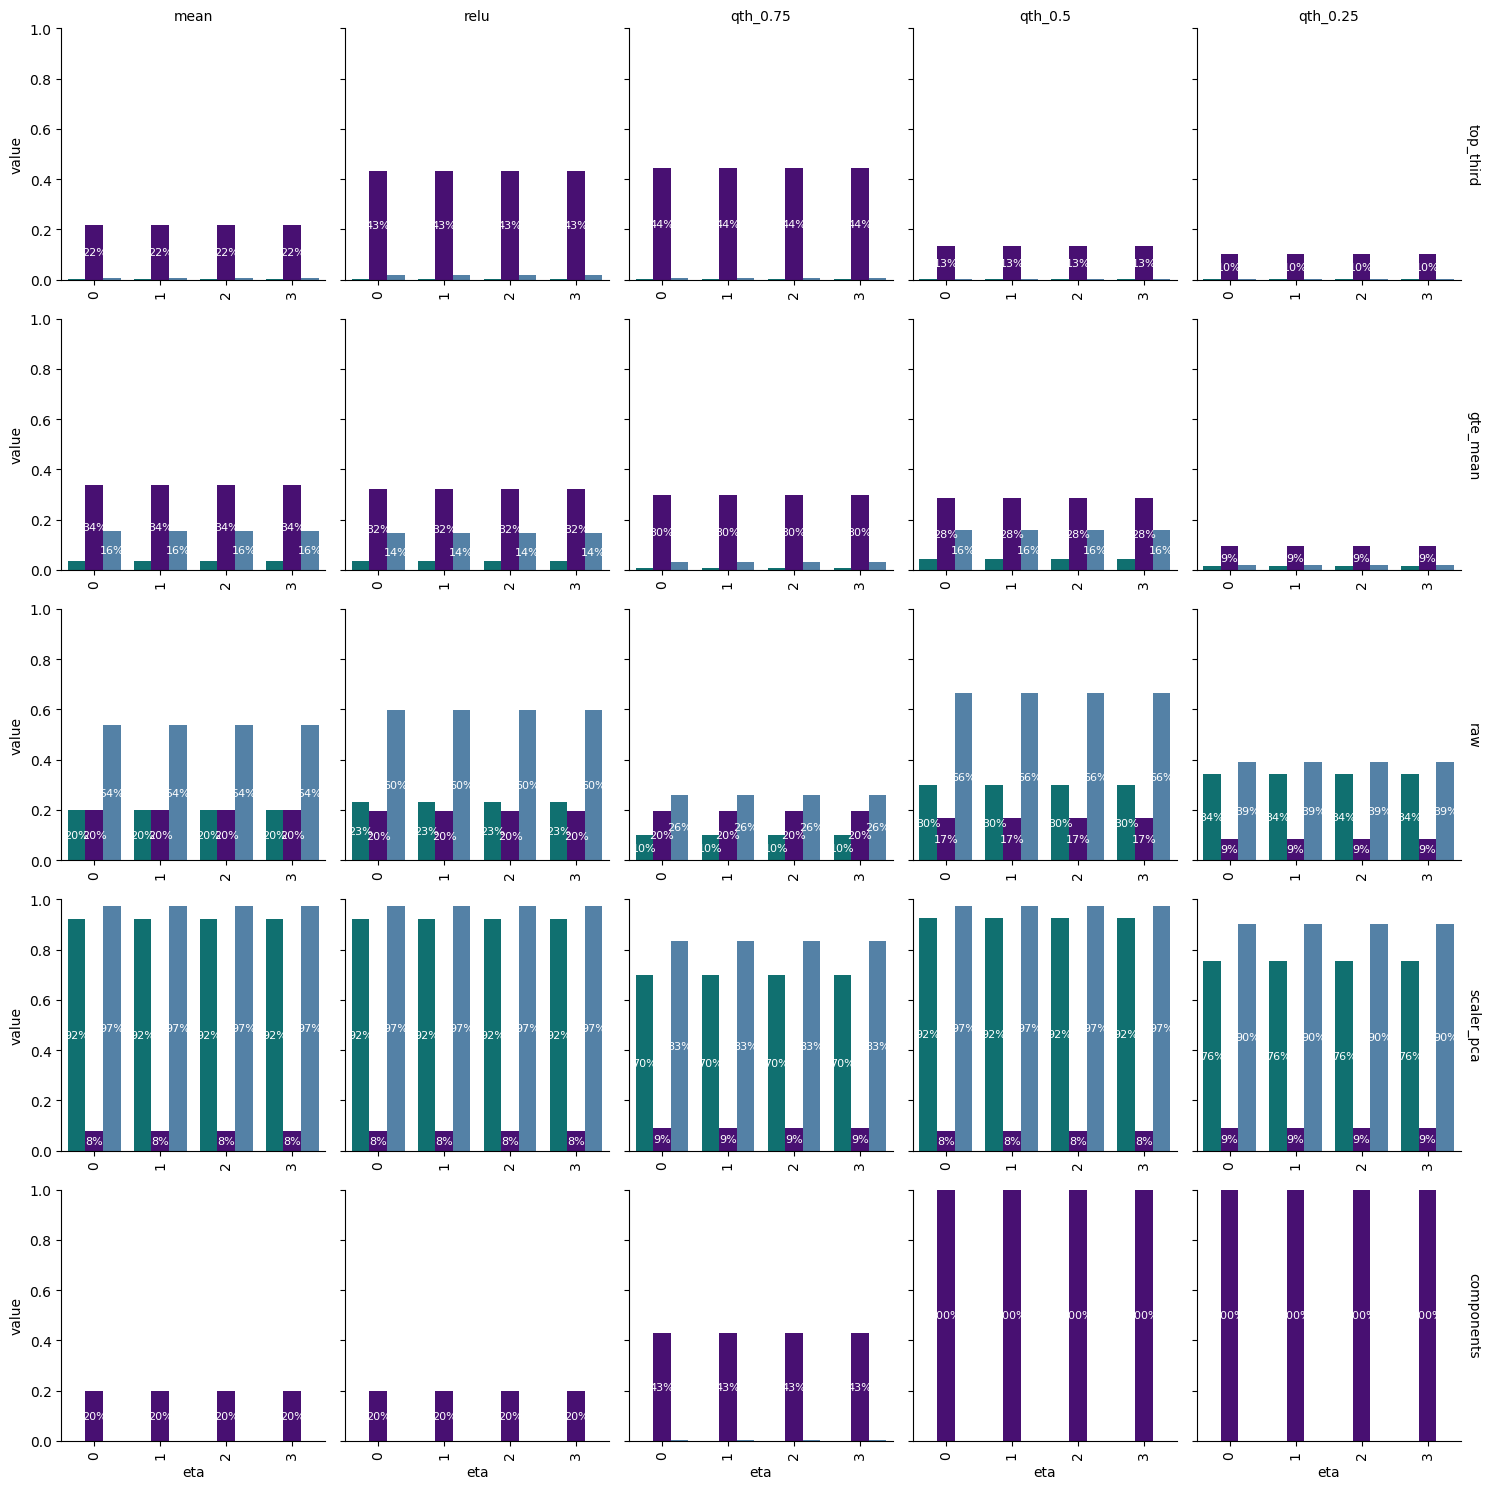

In [129]:
lhl = lhl_neurons[1]

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['stage'] == 'test')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons', 'subset_name', 'eta']]
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons', 'subset_name', 'eta']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="subset_name", margin_titles=True, sharex=False,
                   row_order=flavor_order, col_order=thld_order)

sea.map_dataframe(sns.barplot, "eta", 'value', hue="metric", errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

# RAW Metrics - MEAN - ONE Model

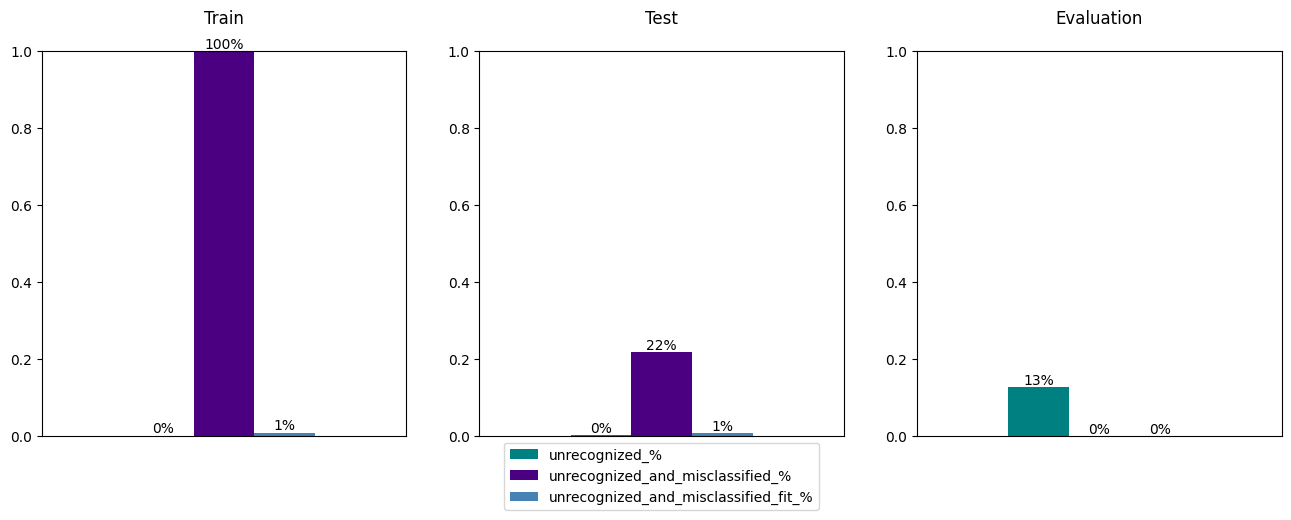

In [130]:
lhl = 30

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['eta'] == 3) & \
    (df_score['flavor'] == 'raw') & \
    (df_score['subset_name'] == 'top_third') & \
    (df_score['thld'] == 'mean')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['stage']]
palette=['teal', 'indigo', 'steelblue']

fig, ax = plt.subplots(1, 3, figsize=(16,5))

for s, a in zip(scores_best_thld_df['stage'].values, ax):
    scores_best_thld_df.loc[scores_best_thld_df['stage']==s, metric_order].plot.bar(color=palette, ax=a)
    a.get_legend().remove()
    a.set_xticks([])
    a.set_title(s.title(), y=1.05)
    


ax[2].legend(loc='best', bbox_to_anchor=(-0.75, -0.5, 0.5, 0.5))

for a in ax:
    a.set_ylim(0, 1)
    a.set_xlabel('')
    for c in a.containers: a.bar_label(c, fmt=lambda x: f'{x*100:.0f}%')

# fig.suptitle(f'{DATASET} - {num_neurons} - ReLU')

plt.show()

In [131]:
df_score.loc[scores_best_thld]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_%,unrecognized_and_misclassified_%,unrecognized_and_misclassified_fit_%,eta,subset_name,num_neurons,stage,thld,flavor,lhl,batch_size
1387,all,59968,2467,20,20,0.000334,1.000000,0.008107,3,top_third,30 (10),train,mean,raw,30,64
1431,all,9984,752,23,5,0.002304,0.217391,0.006649,3,top_third,30 (10),test,mean,raw,30,64
1439,all,1000,0,127,0,0.127000,0.000000,NaN,3,top_third,30 (10),evaluation,mean,raw,30,64


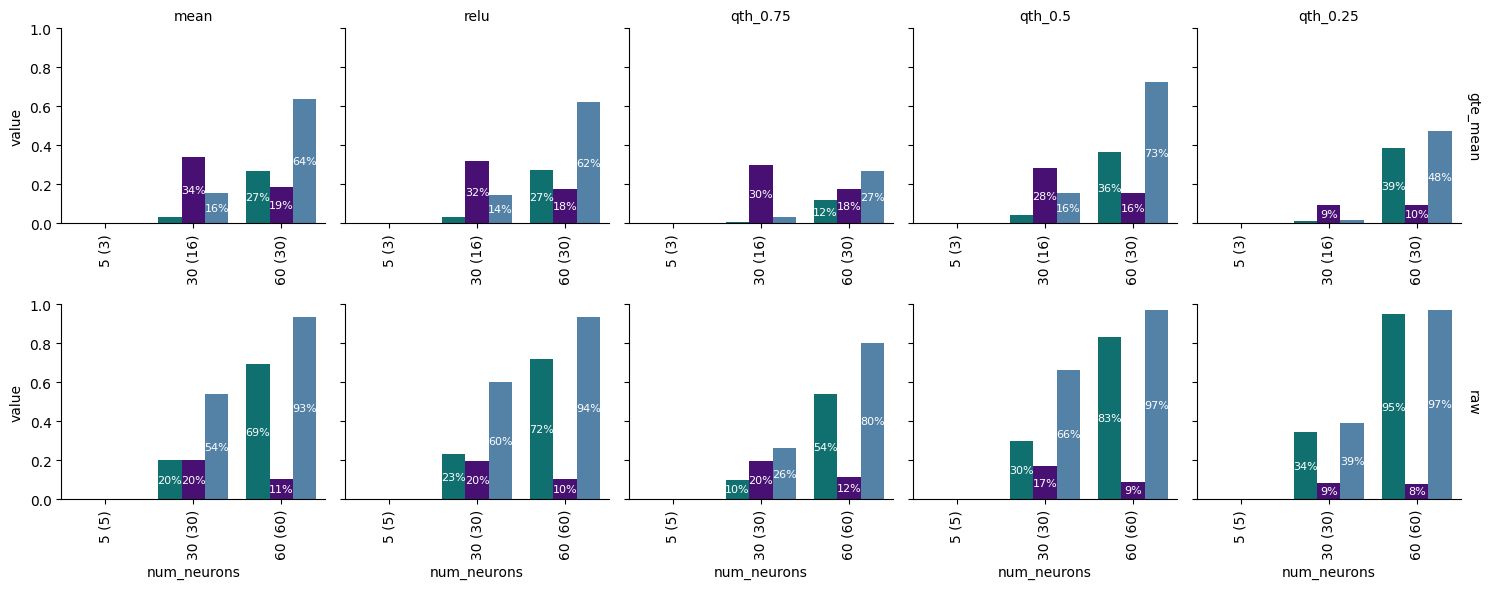

In [132]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] == 'test')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons', 'subset_name']]
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons', 'subset_name']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="subset_name", margin_titles=True, sharex=False,
                   row_order=['gte_mean', 'raw'], col_order=thld_order)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', hue="metric", errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

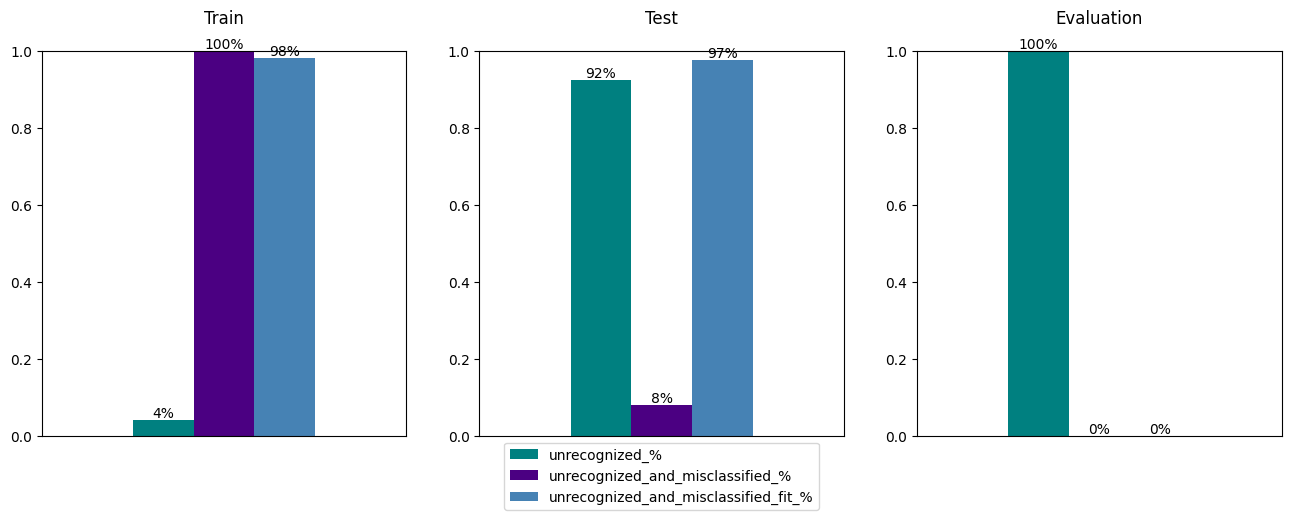

In [133]:
lhl = 30

scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['lhl'] == lhl) & \
    (df_score['eta'] == 3) & \
    (df_score['flavor'] == 'scaler_pca') & \
    (df_score['subset_name'] == 'scaler_pca') & \
    (df_score['thld'] == 'qth_0.5')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['stage']]
palette=['teal', 'indigo', 'steelblue']

fig, ax = plt.subplots(1, 3, figsize=(16,5))

for s, a in zip(scores_best_thld_df['stage'].values, ax):
    scores_best_thld_df.loc[scores_best_thld_df['stage']==s, metric_order].plot.bar(color=palette, ax=a)
    a.get_legend().remove()
    a.set_xticks([])
    a.set_title(s.title(), y=1.05)
    


ax[2].legend(loc='best', bbox_to_anchor=(-0.75, -0.5, 0.5, 0.5))

for a in ax:
    a.set_ylim(0, 1)
    a.set_xlabel('')
    for c in a.containers: a.bar_label(c, fmt=lambda x: f'{x*100:.0f}%')

# fig.suptitle(f'{DATASET} - {num_neurons} - ReLU')

plt.show()

In [134]:
df_score.loc[scores_best_thld]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_%,unrecognized_and_misclassified_%,unrecognized_and_misclassified_fit_%,eta,subset_name,num_neurons,stage,thld,flavor,lhl,batch_size
235,all,59968,2467,2422,2422,0.040388,1.000000,0.981759,3,scaler_pca,30 (30),train,qth_0.5,scaler_pca,30,64
279,all,9984,752,9234,733,0.924880,0.079381,0.974734,3,scaler_pca,30 (30),test,qth_0.5,scaler_pca,30,64
287,all,1000,0,999,0,0.999000,0.000000,NaN,3,scaler_pca,30 (30),evaluation,qth_0.5,scaler_pca,30,64


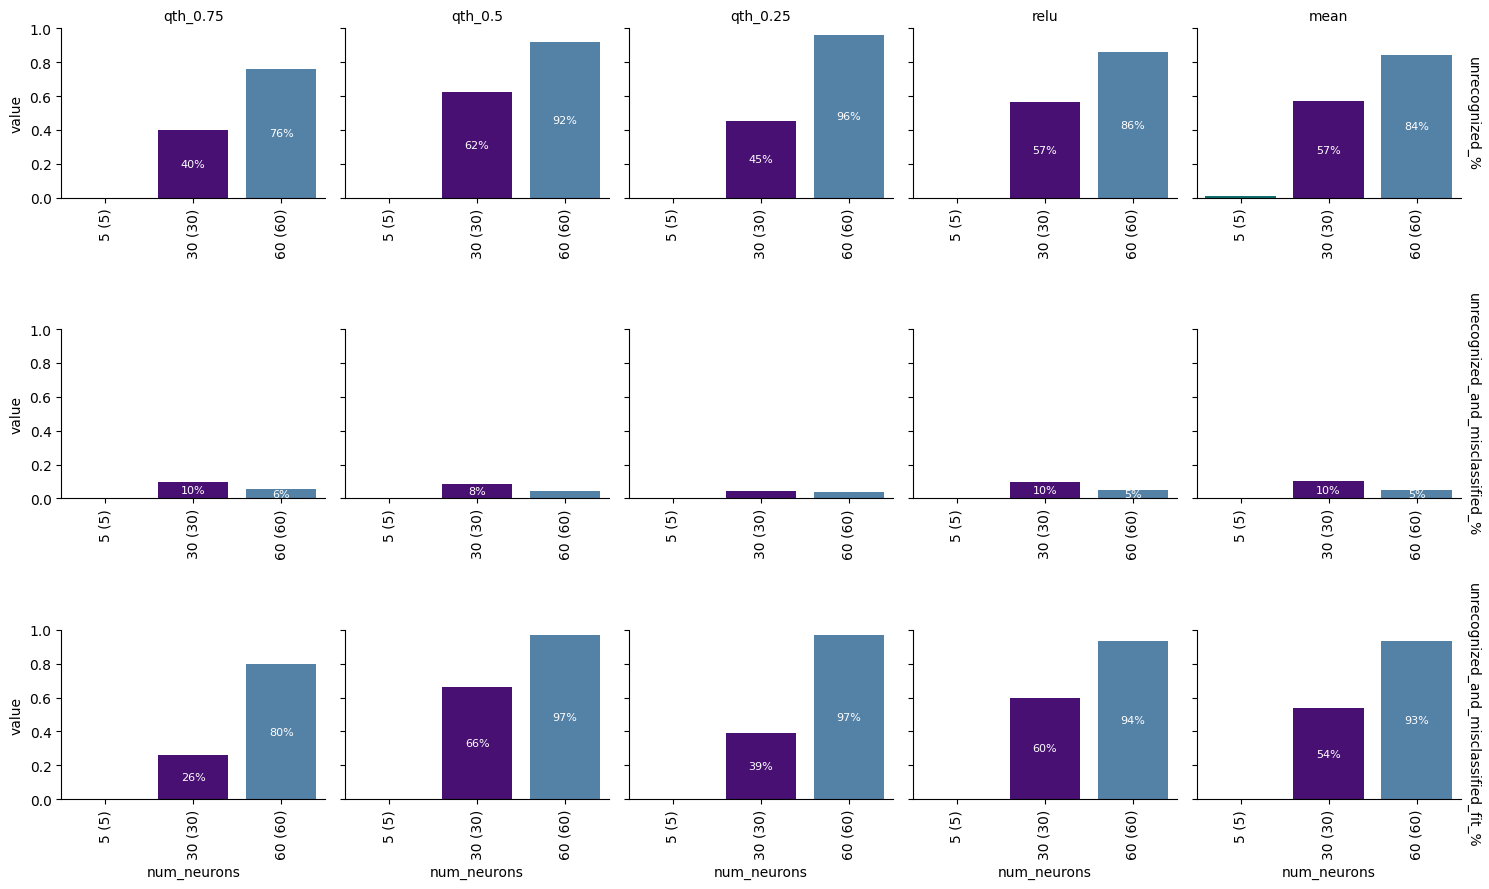

In [135]:
scores_best_thld = (df_score['y'] == 'all') & \
    (df_score['eta'] == 0) & \
    (df_score['stage'] != 'train') & \
    (df_score['flavor'] == 'raw') & \
    (df_score['subset_name'] == 'raw')

scores_best_thld_df = df_score.loc[scores_best_thld, metric_order + ['flavor', 'thld', 'num_neurons']]
palette=['teal', 'indigo', 'steelblue']

scores_best_thld_df = scores_best_thld_df.melt(
    var_name='metric', value_name='value',
    id_vars=['thld', 'flavor', 'num_neurons']
)

sea = sns.FacetGrid(scores_best_thld_df, col="thld", row="metric", margin_titles=True, sharex=False)

sea.map_dataframe(sns.barplot, "num_neurons", 'value', errorbar=None, palette=palette)
add_bar_labels(sea)
# sea.add_legend()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

# BDD Info Charts

In [136]:
df_info['num_neurons'] = df_info.apply(lambda x: f"{x['lhl']} ({x['num_neurons']})", axis=1)

In [137]:
df_info.columns

Index(['thld', 'eta', 'build_time_min', 'size_mb', 'reorder_time_min',
       'num_patterns', 'num_unique_patterns_%', 'num_reorder', 'num_neurons',
       'start_time', 'end_time', 'flavor', 'lhl', 'batch_size', 'subset_name',
       'build_time_hr'],
      dtype='object')

In [138]:
def add_line_labels(sea):
    for k, ax in sea.axes_dict.items():
        # start y from 0
        ax.set_ylim(0, 1)
        # add data labels
        for container in ax.containers:
            ax.bar_label(container, fmt=lambda x: f'{x*100:.0f}%' if x > 0.05 else '',
                         label_type='center' if label_type else 'edge', c='white', fontsize=8)
        # rotate x axis
        for item in ax.get_xticklabels():
            item.set_rotation(90)
            
    sea.set_titles(row_template='{row_name}', col_template='{col_name}')
    try:sea.tight_layout()
    except: ...

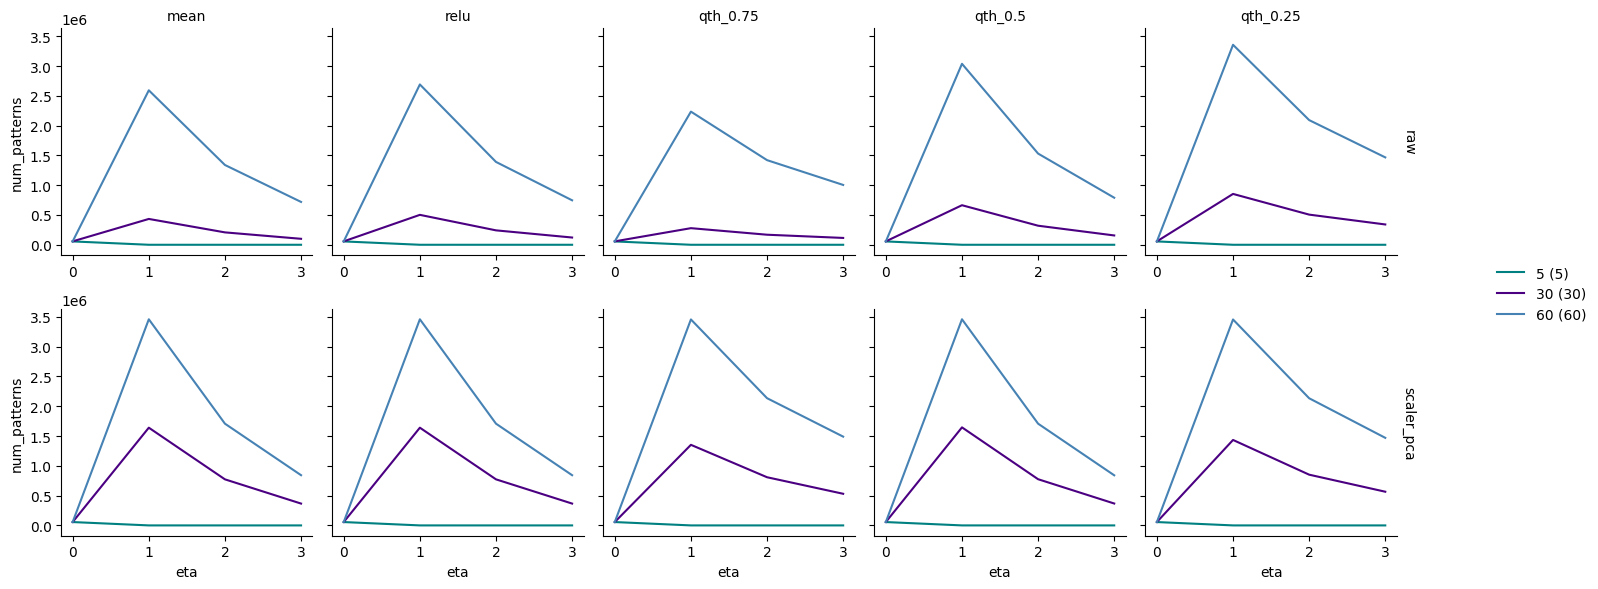

In [139]:
info_fltr = (df_info['subset_name'].isin(['raw', 'scaler_pca']) )

info_fltr_df = df_info.loc[info_fltr, ['thld', 'eta', 'num_neurons', 'subset_name',
                                       'size_mb', 'build_time_min','num_patterns', 'num_unique_patterns_%']]
palette=['teal', 'indigo', 'steelblue']

# info_fltr_df = info_fltr_df.melt(
#     var_name='metric', value_name='value',
#     id_vars=['thld', 'flavor', 'num_neurons', 'subset_name']
# )

sea = sns.FacetGrid(info_fltr_df, col="thld", row="subset_name", margin_titles=True, sharex=False,
                   row_order=['raw', 'scaler_pca'], col_order=thld_order)

sea.map_dataframe(sns.lineplot, "eta", 'num_patterns', hue="num_neurons", palette=palette)
sea.add_legend()

for k, ax in sea.axes_dict.items():
    # start y from 0
    ax.ticklabel_format(useOffset=False)
#     # rotate x axis
#     for item in ax.get_xticklabels():
#         item.set_rotation(90)

sea.set_titles(row_template='{row_name}', col_template='{col_name}')
sea.tight_layout()

# sea.fig.suptitle(f'{DATASET} - compare-all-models-{stage}-{metric}', y=1.03, fontsize=20)

# plt.savefig(path_bdd / f'compare-all-models-{metric}.png', dpi=300, transparent=False)

plt.show()

In [140]:
lhl = 'qth_0.5'
flavor = 'scaler_pca'

In [141]:
temp = pd.pivot_table(
    info_fltr_df.loc[(info_fltr_df['subset_name']==flavor) & (info_fltr_df['thld']==lhl),
                     ['eta', 'num_neurons','num_patterns']],
    index='eta',columns ='num_neurons').astype('int')

temp.columns = [c[1] for c in temp.columns]

temp

,30 (30),5 (5),60 (60)
eta,,,
0.0,57501,56384,57679
1.0,1645830,160,3460260
2.0,775525,64,1707939
3.0,367635,24,841275


In [142]:
temp = pd.pivot_table(
    info_fltr_df.loc[(info_fltr_df['subset_name']==flavor) & (info_fltr_df['thld']==lhl),
                     ['eta', 'num_neurons','num_unique_patterns_%']],
    index='eta',columns ='num_neurons')

temp.columns = [c[1] for c in temp.columns]

temp

,30 (30),5 (5),60 (60)
eta,,,
0.0,95.4,0.1,100.0
1.0,97.9,0.0,100.0
2.0,99.1,0.0,100.0
3.0,99.6,0.0,100.0


In [143]:
temp = pd.pivot_table(
    info_fltr_df.loc[(info_fltr_df['subset_name']==flavor) & (info_fltr_df['thld']==lhl),
                     ['eta', 'num_neurons','build_time_min']],
    index='eta',columns ='num_neurons').astype('int')

temp.columns = [c[1] for c in temp.columns]

temp

,30 (30),5 (5),60 (60)
eta,,,
0.0,2,0,12
1.0,58,0,806
2.0,14,0,398
3.0,4,0,175


In [144]:
temp = pd.pivot_table(
    info_fltr_df.loc[(info_fltr_df['subset_name']==flavor) & (info_fltr_df['thld']==lhl),
                     ['eta', 'num_neurons','build_time_min']],
    index='eta',columns ='num_neurons').astype('int')

temp.columns = [c[1] for c in temp.columns]

temp.cumsum()

,30 (30),5 (5),60 (60)
eta,,,
0.0,2,0,12
1.0,60,0,818
2.0,74,0,1216
3.0,78,0,1391


In [145]:
temp = pd.pivot_table(
    info_fltr_df.loc[(info_fltr_df['subset_name']==flavor) & (info_fltr_df['thld']==lhl),
                     ['eta', 'num_neurons','size_mb']],
    index='eta',columns ='num_neurons').astype('int')

temp.columns = [c[1] for c in temp.columns]

temp

,30 (30),5 (5),60 (60)
eta,,,
0.0,4315,4303,4499
1.0,4323,4303,4507
2.0,4323,4303,4507
3.0,4324,4303,4507


In [146]:
# print('\t'.join(map(str, temp.columns)))
# for c in temp.to_records():
#     print('\t'.join(map(str, c)))
# #     print(c)

# Manual Check for Patterns

In [147]:
model_names

['FashionMNIST_AdamW-64-5/raw',
 'FashionMNIST_AdamW-64-5/scaler_pca',
 'FashionMNIST_AdamW-64-30/raw',
 'FashionMNIST_AdamW-64-30/scaler_pca',
 'FashionMNIST_AdamW-64-60/raw',
 'FashionMNIST_AdamW-64-60/scaler_pca']

In [148]:
t_train = pd.read_csv(base / 'experiments/MNIST/last-hidden-layer/MNIST_SGD-32-30/scaler_pca/MNIST_SGD-32-30_scaler_pca_train.csv')
t_test = pd.read_csv(base / 'experiments/MNIST/last-hidden-layer/MNIST_SGD-32-30/scaler_pca/MNIST_SGD-32-30_scaler_pca_test.csv')
t_eval = pd.read_csv(base / 'experiments/MNIST/last-hidden-layer/MNIST_SGD-32-30/scaler_pca/MNIST_SGD-32-30_scaler_pca_evaluation.csv')
t_true = pd.concat([t_train.loc[t_train['true']==True].copy(), t_test.loc[t_test['true']==True].copy()]).drop_duplicates()
# thld = np.quantile(t_true.drop(['y','true'], axis=1), 0.5, axis=0)
thld=0

In [149]:
t_true_patterns = np.unique((t_true.drop(['y','true'], axis=1) >= thld).astype(np.int8).to_numpy(), axis=0)
t_test_patterns = (t_test.drop(['y','true'], axis=1) >= thld).astype(np.int8).to_numpy()
t_eval_patterns = (t_eval.drop(['y','true'], axis=1) >= thld).astype(np.int8).to_numpy()

In [150]:
t_true_patterns.shape, t_eval_patterns.shape

((62522, 30), (1000, 30))

In [151]:
t_eval_found = np.apply_along_axis(lambda x: (x == t_true_patterns).all(axis=1).sum(), axis=1, arr=t_eval_patterns).sum()
t_eval_found

0

In [152]:
(t_eval_patterns.shape[0] - t_eval_found) / t_eval_patterns.shape[0]

1.0

In [153]:
t_test_patterns.shape

(9984, 30)

In [154]:
t_test_found = np.apply_along_axis(lambda x: (x == t_true_patterns).all(axis=1).sum(), axis=1, arr=t_test_patterns).sum()
t_test_found

9703

In [155]:
(t_test_patterns.shape[0] - t_test_found) / t_test_patterns.shape[0]

0.028145032051282052

In [156]:
t_true_patterns = (t_true.drop(['y','true'], axis=1) >= thld).astype(np.int8).to_numpy()

In [157]:
t_true_patterns.shape

(67897, 30)

In [158]:
def flip_pattern(patterns, eta):
    """flip n-th bit to allow more freedom(false positive)
       if eta = 0 then pattern as is
       if eta = 1 then loop over each bit and force it to one
       eta = 2 loop over 2 bits and flip them ... etc
       drop any duplicate patterns"""
    temp = patterns.copy()
    
    for nth in range(patterns.shape[1]-eta+1):
        t1 = temp.copy()
        t0 = temp.copy()
        
        t1[:, nth:nth+eta] = 1
        t0[:, nth:nth+eta] = 0
        
        # compare hamming distance to original
        idx1 = (patterns ^ t1).sum(1) == eta
        idx0 = (patterns ^ t0).sum(1) == eta
        
        if idx1.sum() == 0 and idx0.sum() == 0: continue

        # pick rows with respect to eta
        yield np.vstack([np.unique(t1[idx1], axis=0), np.unique(t0[idx0], axis=0)])

In [159]:
eta_1_0 = 0
for p in flip_pattern(t_true_patterns, 1):
    eta_1_0 += p.shape[0]

eta_1_0

1875660

In [160]:
def flip_pattern(patterns, eta):
    """flip n-th bit to allow more freedom(false positive)
       if eta = 0 then pattern as is
       if eta = 1 then loop over each bit and force it to one
       eta = 2 loop over 2 bits and flip them ... etc
       drop any duplicate patterns"""
    temp = patterns.copy()
    
    for nth in range(patterns.shape[1]-eta+1):
        t1 = temp.copy()
        t0 = temp.copy()
        
        t1[:, nth:nth+eta] = 1
        
        # compare hamming distance to original
        idx1 = (patterns ^ t1).sum(1) == eta
        
        if idx1.sum() == 0: continue

        # pick rows with respect to eta
        yield np.unique(t1[idx1], axis=0)